# YOLOv2

## Prepare Data
### Preparing Pascal VOC 2007
To Prepare the data first go to Examples/Images/DataSets/Pascal and install the data with the install_data.py scripts. 
Then go to Examples/Images/DataSets/Pascal/mappings and run create_mappings.py to preprocess the ground truth boxes.

## Train the model

In [1]:
import os, sys
import Distributed_YOLOv2 as dy
import PARAMETERS as par
import YOLOv2 as yolo2
from ErrorFunction import get_error
from cntk import input_variable, Communicator


In [2]:
model = yolo2.create_yolov2_net(par)
image_input = input_variable((par.par_num_channels, par.par_image_height, par.par_image_width), name="data")
output = model(image_input)  # append model to image input

# input for ground truth boxes
num_gtb = par.par_max_gtbs
gtb_input = input_variable((num_gtb * 5))  # 5 for class, x,y,w,h

if not par.par_boxes_centered:
    original_shape = gtb_input.shape
    new_shape = (num_gtb, 5)
    reshaped = reshape(gtb_input, new_shape)
    xy = reshaped[:,0:2]
    wh = reshaped[:,2:4]
    cls = reshaped[:,4:]
    center_xy = xy + wh*.5
    new_gtb = splice(xy,wh,cls,axis=1)
    gtb_transformed = reshape(new_gtb, gtb_input.shape)
else:
    gtb_transformed = gtb_input

mse = get_error(output, gtb_transformed, cntk_only=False)# + zero

network = {
    'feature': image_input,
    'gtb_in': gtb_input,
    'mse': mse,
    'output': output
}



#from cntk.logging.graph import plot
#plot(output, "./yopar.png")
#plot(network['mse'], "./yolo_mse.png")



In [3]:
data_path = os.path.join(par.par_abs_path, "..", "..", "DataSets","Pascal", "mappings")

train_image_file = os.path.join(data_path, par.par_train_data_file)
train_gt_file = os.path.join(data_path, par.par_train_roi_file)

test_image_file =None # os.path.join(data_path, par.par_test_data_file)
test_gt_file =None # os.path.join(data_path, par.par_test_roi_file)

log_dir = None

In [4]:
base_lr = 1e-3
#par.par_lr_schedule = [base_lr * 0.1]*10 + [base_lr * 1]*30
par.par_lr_schedule = [base_lr]*60 + [base_lr * 0.1]*30 + [base_lr * 0.01]
par.par_max_epochs = 160
par.par_minibatch_size = 128

In [5]:
#training!
try:
    output = dy.yolov2_train_and_eval(network, 
                                   train_image_file, train_gt_file,
                                   test_image_file, test_gt_file,
                                   max_epochs=par.par_max_epochs,
                                   log_to_file=log_dir,
                                   num_mbs_per_log=50,
                                   minibatch_size=par.par_minibatch_size,
                                   epoch_size=par.par_epoch_size,
                                   gen_heartbeat=False)

finally:
    Communicator.finalize()
    print("Training finished!")

Finished Epoch[1 of 160]: [Training] loss = 17.408244 * 5120, metric = 1740.82% * 5120 46.784s (109.4 samples/s);
Finished Epoch[2 of 160]: [Training] loss = 5.552585 * 4992, metric = 555.26% * 4992 27.099s (184.2 samples/s);
Finished Epoch[3 of 160]: [Training] loss = 5.496876 * 4992, metric = 549.69% * 4992 27.861s (179.2 samples/s);
Finished Epoch[4 of 160]: [Training] loss = 5.491398 * 4992, metric = 549.14% * 4992 27.654s (180.5 samples/s);
Finished Epoch[5 of 160]: [Training] loss = 5.522795 * 4992, metric = 552.28% * 4992 27.217s (183.4 samples/s);
Finished Epoch[6 of 160]: [Training] loss = 5.621556 * 4992, metric = 562.16% * 4992 27.218s (183.4 samples/s);
Finished Epoch[7 of 160]: [Training] loss = 5.718833 * 5120, metric = 571.88% * 5120 29.542s (173.3 samples/s);
Finished Epoch[8 of 160]: [Training] loss = 5.895141 * 4992, metric = 589.51% * 4992 27.576s (181.0 samples/s);
Finished Epoch[9 of 160]: [Training] loss = 6.069395 * 4992, metric = 606.94% * 4992 27.136s (184.0 sa

Finished Epoch[74 of 160]: [Training] loss = 5.423661 * 4992, metric = 542.37% * 4992 25.017s (199.5 samples/s);
Finished Epoch[75 of 160]: [Training] loss = 5.429696 * 5120, metric = 542.97% * 5120 26.275s (194.9 samples/s);
Finished Epoch[76 of 160]: [Training] loss = 5.466010 * 4992, metric = 546.60% * 4992 25.157s (198.4 samples/s);
Finished Epoch[77 of 160]: [Training] loss = 5.465560 * 4992, metric = 546.56% * 4992 24.980s (199.8 samples/s);
Finished Epoch[78 of 160]: [Training] loss = 5.462299 * 4992, metric = 546.23% * 4992 25.308s (197.2 samples/s);
Finished Epoch[79 of 160]: [Training] loss = 5.473413 * 4992, metric = 547.34% * 4992 24.811s (201.2 samples/s);
Finished Epoch[80 of 160]: [Training] loss = 5.464731 * 4992, metric = 546.47% * 4992 25.364s (196.8 samples/s);
Finished Epoch[81 of 160]: [Training] loss = 5.483435 * 5120, metric = 548.34% * 5120 25.780s (198.6 samples/s);
Finished Epoch[82 of 160]: [Training] loss = 5.462026 * 4992, metric = 546.20% * 4992 25.355s (1

Finished Epoch[147 of 160]: [Training] loss = 5.526899 * 4992, metric = 552.69% * 4992 25.120s (198.7 samples/s);
Finished Epoch[148 of 160]: [Training] loss = 5.534159 * 4992, metric = 553.42% * 4992 24.813s (201.2 samples/s);
Finished Epoch[149 of 160]: [Training] loss = 5.549372 * 5120, metric = 554.94% * 5120 25.439s (201.3 samples/s);
Finished Epoch[150 of 160]: [Training] loss = 5.523717 * 4992, metric = 552.37% * 4992 24.988s (199.8 samples/s);
Finished Epoch[151 of 160]: [Training] loss = 5.584693 * 4992, metric = 558.47% * 4992 24.807s (201.2 samples/s);
Finished Epoch[152 of 160]: [Training] loss = 5.555224 * 4992, metric = 555.52% * 4992 25.074s (199.1 samples/s);
Finished Epoch[153 of 160]: [Training] loss = 5.528014 * 4992, metric = 552.80% * 4992 24.978s (199.9 samples/s);
Finished Epoch[154 of 160]: [Training] loss = 5.519661 * 4992, metric = 551.97% * 4992 25.251s (197.7 samples/s);
Finished Epoch[155 of 160]: [Training] loss = 5.542867 * 5120, metric = 554.29% * 5120 2

In [6]:
output_dir = "."
if output is not None and output_dir is not None:
    save_path = os.path.join(output_dir, "YOLOv2.model")
    output.save(save_path)
    print("Saved model to " + save_path)
trained_model = output

Saved model to .\YOLOv2.model


In [7]:
from cntk import load_model
trained_model = load_model(os.path.join(".", "YOLOv2.model"))

## Evaluate

Box out of bounds: (165,-18) (418,309)
Box out of bounds: (202,-45) (381,377)
Box out of bounds: (23,48) (385,157)
Box out of bounds: (73,62) (393,267)
Box out of bounds: (56,-17) (411,173)


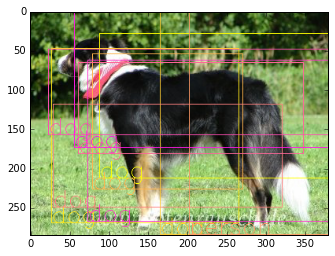

Box out of bounds: (187,178) (274,376)
Box out of bounds: (4,36) (534,317)


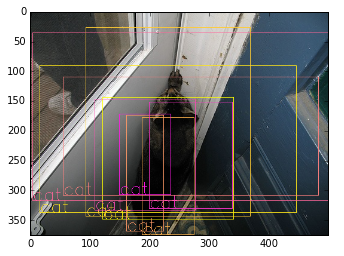

Box out of bounds: (52,112) (255,380)
Box out of bounds: (67,-7) (471,239)
Box out of bounds: (47,99) (183,391)
Box out of bounds: (-14,48) (322,286)
Box out of bounds: (-13,73) (244,307)
Box out of bounds: (-37,130) (268,352)
Box out of bounds: (-60,-3) (137,324)


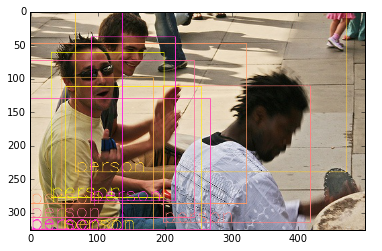

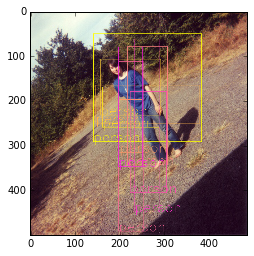

Box out of bounds: (-34,52) (342,282)
Box out of bounds: (-66,96) (374,289)
Box out of bounds: (-69,118) (300,369)
Box out of bounds: (-20,141) (328,302)
Box out of bounds: (-31,119) (415,269)
Box out of bounds: (54,141) (329,342)
Box out of bounds: (223,42) (546,285)


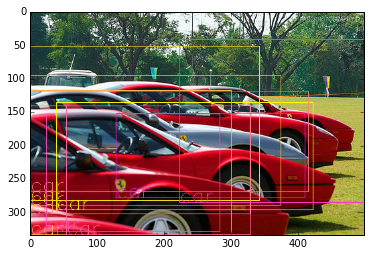

Box out of bounds: (-6,71) (238,325)
Box out of bounds: (-53,132) (284,313)
Box out of bounds: (98,-41) (444,540)
Box out of bounds: (-24,116) (296,625)
Box out of bounds: (136,88) (406,495)
Box out of bounds: (165,-17) (377,512)
Box out of bounds: (-11,72) (283,334)
Box out of bounds: (-7,181) (333,535)
Box out of bounds: (80,199) (462,455)
Box out of bounds: (64,-44) (316,372)
Box out of bounds: (52,39) (381,464)
Box out of bounds: (273,140) (352,498)
Box out of bounds: (418,232) (505,508)
Box out of bounds: (229,320) (540,374)
Box out of bounds: (324,306) (600,453)
Box out of bounds: (223,304) (622,389)
Box out of bounds: (392,301) (453,440)
Box out of bounds: (419,277) (504,400)
Box out of bounds: (18,286) (58,440)
Box out of bounds: (274,327) (341,435)
Box out of bounds: (-9,288) (86,468)
Box out of bounds: (364,273) (482,481)
Box out of bounds: (259,242) (356,378)
Box out of bounds: (136,201) (325,409)
Box out of bounds: (121,213) (263,397)
Box out of bounds: (48,217) (336,381)
B

In [8]:
%matplotlib inline
import evaluate
import cv2
import numpy as np
from cntk import logging

data_input = logging.graph.find_by_name(trained_model, "data")
img_width = data_input.shape[2]
img_height= data_input.shape[1]


obj_min, obj_max=1, 0
data_path= r"../../DataSets/Pascal/VOCdevkit/VOC2007/JPEGImages"
img_list = [18,118,1118,27,2118,4118,1,2,3,4,5,6,7,8,9,10]
# img_list = open(r"..\..\DataSets\Pascal\VOCdevkit\VOC2007\ImageSets\Main\test.txt").read().split()
save_path = os.path.join(".", "outputdir", "results", "pvoc2007")
if not os.path.exists(save_path):
    results_dir = os.path.join(".", "outputdir", "results")
    if not os.path.exists(results_dir):
        output_dir = os.path.join(".", "outputdir")
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        os.mkdir(results_dir)
    os.mkdir(save_path)

for i in range(len(img_list)):
    img_name =  "{:06}.jpg".format(img_list[i])
    img = evaluate.load_image(os.path.join(data_path, img_name))

    preds = evaluate.predictions_for_image(img, trained_model, img_width, img_height)
    preds_nms = evaluate.do_nms(preds)
    #import ipdb;ipdb.set_trace()
    color_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    evaluate.draw_bb_on_image(color_image, preds_nms)

    if i<5:
        evaluate.plot_image(color_image)

    out_img = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)

    evaluate.save_image(out_img, save_path, "bb_"+img_name)

    #import math
    objectnesses = preds[:,4]
    obj_min = np.minimum(obj_min, np.minimum.reduce(objectnesses))
    obj_max = np.maximum(obj_max, np.maximum.reduce(objectnesses))
print((obj_min,obj_max))
